In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/")

In [3]:
import torch
import numpy as np
import ml_collections
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusion_holder import DiffusionRunner
from transformers import BertConfig, BertTokenizerFast

from diffusion_holder import DiffusionRunner
from utils.util import set_seed, dict_to_cuda
from estimation_utils.util import estimate_model, reduce_metrics, gather_texts
import diffusion_utils.schedulers as schedulers

In [4]:
sns.set_theme()

# Исследование лосса в зависимости от координат

In [5]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints'
    training.batch_size = 512
    config.checkpoints_prefix = None

    validation = config.validation = ml_collections.ConfigDict()
    validation.batch_size = 512

    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 200
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False
    sde.scheduler = schedulers.CosineSD(d=10)

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "encodings"
    model.dif_enc_type = "base"
    model.downstream_task = "sst2"  # "qqp"
    model.dataset = "wikipedia-clean"  # "glue"
    model.prediction = "x_0"
    model.loss = "L_x_0"
    model.decoder_path = "decoder-wikipedia-128.pth"  # "decoder-wikipedia-128.pth"  # "decoder-t5_base-wikipedia-128.pth"
    model.dim = 768
    
    data = config.data = ml_collections.ConfigDict()
    data.max_sequence_len = 96
    data.pos_begin = 0.0
    data.pos_end = 0.67
    data.enc_bert_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-mean.pt"
    data.enc_bert_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-std.pt"
    data.enc_t5_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-mean.pth"
    data.enc_t5_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-std.pth"
    
    
    config.finetuning = False
    config.seed = 0
    config.ddp = False
    config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

    config.project_name = "bert-conditional-exps"

    return config

In [6]:
config = create_config()
config.checkpoints_prefix = "wikipedia-clean--prediction=x_0-loss=L_x_0-seq_len=96-cond_seg=[0.00, 0.67]-clipgrad=1.0-lr=0.0002-min_lr=0.0002-lin_input=True-seed=0-wd=0.01-batch=512-SD=10-t5-bert-womask_800000_"

diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True)

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-base were not used when initializing T5EncoderModel: ['decoder.block.6.layer.1.layer_norm.weight', 'decoder.block.6.layer.1.EncDecAttention.q.weight', 'decoder.block.2.lay

In [7]:
diffusion.set_valid_data_generator()

In [8]:
loader = iter(diffusion.valid_loader)

## Лосс реконструкции на валидации в произвольный момент времени

In [19]:
X = next(loader)
X = dict_to_cuda(X)

with torch.no_grad():
    clean_X = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
    cond = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})

In [20]:
clean_X.shape, cond.shape

(torch.Size([512, 96, 768]), torch.Size([512, 96, 768]))

In [21]:
batch_size = clean_X.shape[0]

In [22]:
t = diffusion.sample_time(batch_size)
marg_forward = diffusion.sde.marginal_forward(clean_X, t)
x_t, noise, score_clean = marg_forward['x_t'], marg_forward['noise'], marg_forward['score']

In [23]:
with torch.no_grad():
    scores = diffusion.sde.calc_score(
        diffusion.ddp_score_estimator, 
        x_t, 
        t, 
        cond=cond, 
        cond_mask=X["cond_mask"],
        attention_mask=None
    )

In [24]:
x_0 = scores["x_0"]

In [25]:
losses = torch.mean(torch.square(x_0 - clean_X), dim=[0, 1])

In [26]:
torch.mean(losses)

tensor(0.4218, device='cuda:0')

In [27]:
torch.mean(losses[:128])

tensor(0.4234, device='cuda:0')

In [28]:
torch.mean(losses[:64])

tensor(0.4223, device='cuda:0')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


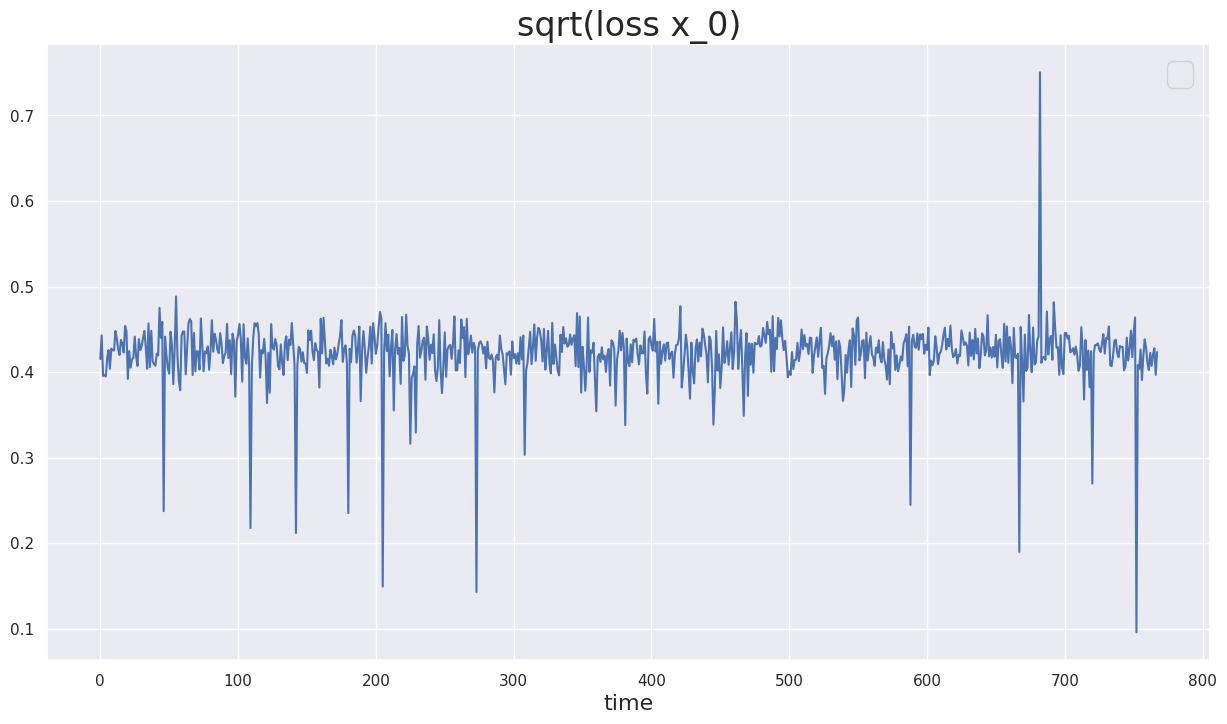

In [30]:
plt.figure(figsize=(15, 8))
plt.yticks(np.arange(0, 1.05, 0.1))
plt.xlabel('time', fontsize=16)
plt.ylabel('', fontsize=24)
plt.title("sqrt(loss x_0)", fontsize=24)

plt.plot(losses.detach().cpu().numpy())

plt.legend(fontsize=24)
plt.show()

In [31]:
losses_mean = []
for i in range(1, len(losses)):
    losses_mean.append(torch.mean(losses[:i]).item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


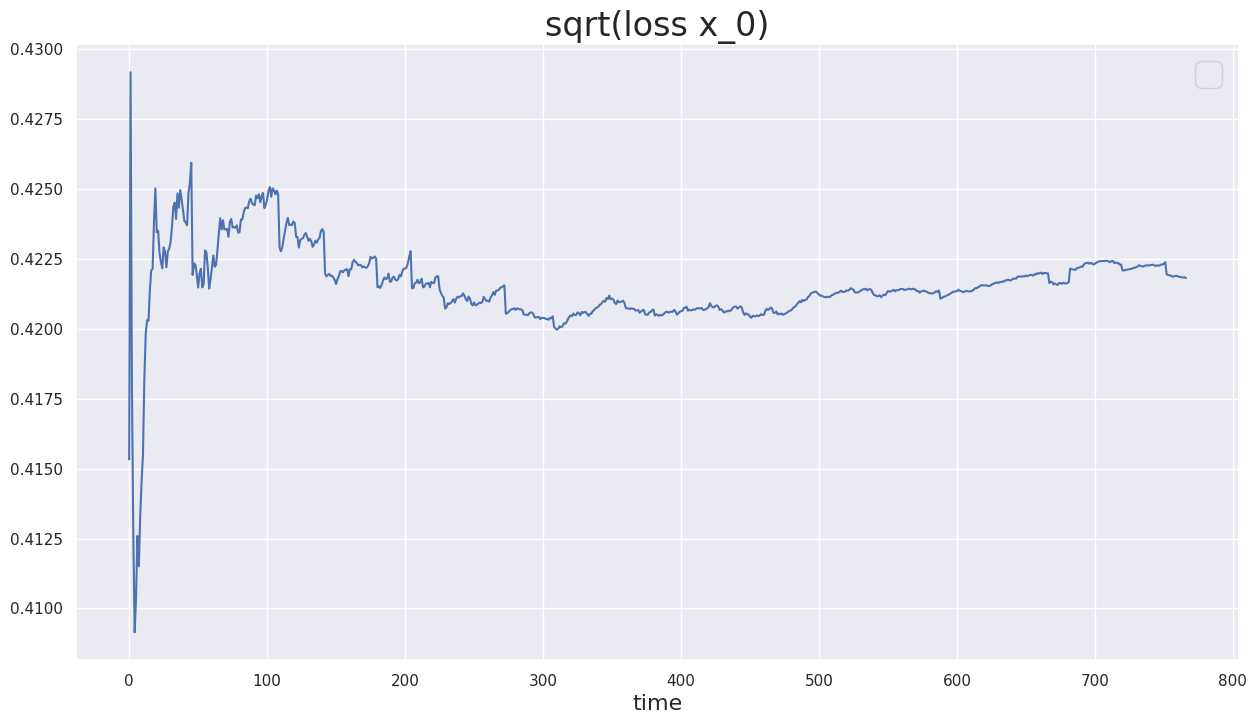

In [33]:
plt.figure(figsize=(15, 8))
#plt.yticks(np.arange(0, 1.05, 0.1))
plt.xlabel('time', fontsize=16)
plt.ylabel('', fontsize=24)
plt.title("sqrt(loss x_0)", fontsize=24)

plt.plot(losses_mean)

plt.legend(fontsize=24)
plt.show()

# Лосс для сети, которая предсказывает удвоенную карту признаков

In [34]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints'
    training.batch_size = 512
    config.checkpoints_prefix = None

    validation = config.validation = ml_collections.ConfigDict()
    validation.batch_size = 512

    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 200
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False
    sde.scheduler = schedulers.CosineSD(d=10)

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "encodings"
    model.dif_enc_type = "base"
    model.downstream_task = "sst2"  # "qqp"
    model.dataset = "wikipedia-clean"  # "glue"
    model.prediction = "x_0"
    model.loss = "L_x_0"
    model.dim = int(768 * 2)
    model.decoder_path = f"decoder-bert-encs-{model.dim}.pth"
    
    data = config.data = ml_collections.ConfigDict()
    data.max_sequence_len = 96
    data.pos_begin = 0.0
    data.pos_end = 0.67
    data.enc_bert_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-mean.pt"
    data.enc_bert_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-std.pt"
    data.enc_t5_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-mean.pth"
    data.enc_t5_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-std.pth"
    
    
    config.finetuning = False
    config.seed = 0
    config.ddp = False
    config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

    config.project_name = "bert-conditional-exps"

    return config

In [ ]:
config = create_config()
config.checkpoints_prefix = "wikipedia-clean--prediction=x_0-loss=L_x_0-seq_len=96-cond_seg=[0.00, 0.67]-clipgrad=1.0-lr=0.0002-min_lr=0.0002-lin_input=True-seed=0-wd=0.01-batch=512-SD=10-t5-bert-womask_800000_"

diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True)

# Проверка линейной зависимости фичей

In [5]:
from torch.utils.data import DataLoader

In [6]:
from data.dataset_clean_wiki import WikipediaCleanDataset
from model.enc_normalizer import EncNormalizer
from model.bert_encoder import BertEncoderModel

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [8]:
test_dataset = next(WikipediaCleanDataset(
    split="test",
    tokenizer_bert=tokenizer,
    tokenizer_cond=tokenizer,
    tokenizer_gen=tokenizer,
    max_sequence_len=128,
    pos_begin=0.,
    pos_end=0.,
).get_data())

In [9]:
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)

In [10]:
bert_cfg = "bert-base-uncased"
gen_enc_normalizer = EncNormalizer(
    enc_mean_path="/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-mean.pt",
    enc_std_path="/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-std.pt",
)
encoder_gen = BertEncoderModel.from_pretrained(
    bert_cfg, enc_normalizer=gen_enc_normalizer
).eval().cuda()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertEncoderModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertEncoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEncoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertEncoderModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['enc_normalizer.enc_std', 'enc_normalizer.enc_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

In [41]:
class NN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()

        self.hidden_size = 768
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(input_size, self.hidden_size),
            torch.nn.GELU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.GELU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.GELU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.GELU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.GELU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.GELU(),
            torch.nn.Linear(self.hidden_size, output_size),
        )

        # self.ffn = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.ffn(x)

In [43]:
input_size = 384
output_size = 768 - input_size

model = NN(input_size, output_size).cuda()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [13]:
from IPython.display import clear_output

In [ ]:
loss_epoch = []
model.train()

for step, X in tqdm(enumerate(train_loader), total=len(train_loader)):
    with torch.no_grad():
        X = dict_to_cuda(X)
        clean_X = encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
        
    x = clean_X[..., :input_size].cuda()
    target = clean_X[..., input_size:].cuda()

    pred = model(x)
    loss = torch.mean(torch.square(target - pred))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_epoch.append(loss.item())

    if step % 50 == 0:  
        clear_output()
        plt.figure(figsize=(15, 8))
        plt.xlabel('step', fontsize=16)
        plt.ylabel('loss', fontsize=24)
        
        plt.plot(loss_epoch)
        plt.show()

In [56]:
model.load_state_dict(torch.load("ffn_correlation_model.pth"))

<All keys matched successfully>

In [57]:
model.eval()

NN(
  (ffn): Sequential(
    (0): Linear(in_features=384, out_features=768, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=768, out_features=768, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=768, out_features=768, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=768, out_features=768, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=768, out_features=768, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=768, out_features=768, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=768, out_features=384, bias=True)
  )
)

In [58]:
X = next(iter(test_loader))

with torch.no_grad():
    X = dict_to_cuda(X)
    clean_X = encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})

    x = clean_X[..., :input_size].cuda()
    target = clean_X[..., input_size:].cuda()

    pred = model(x)
    loss = torch.square(target - pred)

In [59]:
torch.sort(torch.mean(loss, dim=[0, 1]))

torch.return_types.sort(
values=tensor([0.0442, 0.0695, 0.1111, 0.1576, 0.1781, 0.1813, 0.1815, 0.1876, 0.1897,
        0.1977, 0.2023, 0.2040, 0.2047, 0.2124, 0.2136, 0.2141, 0.2165, 0.2216,
        0.2218, 0.2222, 0.2234, 0.2244, 0.2256, 0.2261, 0.2263, 0.2274, 0.2277,
        0.2282, 0.2289, 0.2292, 0.2295, 0.2303, 0.2309, 0.2310, 0.2310, 0.2348,
        0.2349, 0.2355, 0.2360, 0.2366, 0.2370, 0.2380, 0.2388, 0.2389, 0.2394,
        0.2397, 0.2397, 0.2398, 0.2399, 0.2400, 0.2402, 0.2404, 0.2406, 0.2416,
        0.2417, 0.2418, 0.2424, 0.2425, 0.2428, 0.2428, 0.2430, 0.2434, 0.2435,
        0.2435, 0.2436, 0.2439, 0.2439, 0.2441, 0.2442, 0.2442, 0.2452, 0.2452,
        0.2452, 0.2453, 0.2454, 0.2459, 0.2461, 0.2462, 0.2462, 0.2462, 0.2462,
        0.2465, 0.2471, 0.2473, 0.2484, 0.2486, 0.2488, 0.2491, 0.2491, 0.2492,
        0.2493, 0.2494, 0.2495, 0.2495, 0.2496, 0.2498, 0.2503, 0.2509, 0.2510,
        0.2513, 0.2517, 0.2518, 0.2519, 0.2520, 0.2521, 0.2521, 0.2522, 0.2522,
        

In [39]:
weights = next(model.parameters())

In [40]:
torch.sort(weights[0], descending=True)

torch.return_types.sort(
values=tensor([ 8.0251e-02,  5.4759e-03,  3.9220e-03,  3.8826e-03,  8.6039e-04,
         3.0049e-04,  2.7922e-04,  2.1516e-04,  1.9138e-04,  1.1816e-04,
         1.1607e-04,  1.0886e-04,  1.0341e-04,  1.0252e-04,  9.5635e-05,
         9.2086e-05,  8.6395e-05,  8.3453e-05,  8.2880e-05,  7.8656e-05,
         7.6524e-05,  7.6453e-05,  7.4382e-05,  7.2285e-05,  7.1948e-05,
         7.1645e-05,  7.0431e-05,  6.9548e-05,  6.9087e-05,  6.4821e-05,
         6.4370e-05,  6.3899e-05,  6.3693e-05,  6.1995e-05,  6.0772e-05,
         6.0343e-05,  6.0020e-05,  5.9850e-05,  5.5758e-05,  5.5062e-05,
         5.1456e-05,  5.0620e-05,  5.0558e-05,  5.0077e-05,  4.9695e-05,
         4.9687e-05,  4.9395e-05,  4.9358e-05,  4.8576e-05,  4.8020e-05,
         4.7910e-05,  4.6417e-05,  4.5840e-05,  4.5762e-05,  4.4975e-05,
         4.4630e-05,  4.4298e-05,  4.4245e-05,  4.4128e-05,  4.3837e-05,
         4.3177e-05,  4.2869e-05,  4.2744e-05,  4.2480e-05,  4.2399e-05,
         4.0870e-05

# Reconstruction loss

In [10]:
def create_config():
    config = ml_collections.ConfigDict()
    optim = config.optim = ml_collections.ConfigDict()
    optim.grad_clip_norm = 1.
    optim.linear_warmup = 5000
    optim.lr = 2e-4
    optim.min_lr = 2e-4
    optim.warmup_lr = 1e-8
    optim.weight_decay = 0.01
    optim.beta_1 = 0.9
    optim.beta_2 = 0.98
    optim.eps = 1e-6

    training = config.training = ml_collections.ConfigDict()
    training.training_iters = 1_000_000
    training.training_iters = training.training_iters
    training.checkpoint_freq = 50_000
    training.eval_freq = 50_000
    training.batch_size = 512  # * 8

    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints/'
    config.checkpoints_prefix = ''

    loss = config.loss = ml_collections.ConfigDict()
    loss.ce_coef = 0.

    refresh = config.refresh = ml_collections.ConfigDict()
    refresh.true = False
    refresh.prefix = "../checkpoints/wikipedia--prediction=x_0-loss=L_x_0-seq_len=96-cond_seg=[0.00, 0.67]-clipgrad=10.0-lr=0.0002-min_lr=0.0002-seed=0-wd=0.01-batch=512-SD=10-t5-mybert-220000_400000_.pth"
    refresh.wand_id = "g5fb4af3"

    validation = config.validation = ml_collections.ConfigDict()
    validation.batch_size = 128
    validation.validation_iters = int(10_000 / validation.batch_size)
    validation.num_gen_texts = 8192
    validation.p_uncond = 0.

    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 200
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False
    sde.coef_d = 10
    sde.scheduler = schedulers.CosineSD(d=sde.coef_d)

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "embeddings"
    model.dif_enc_type = "base"
    model.downstream_task = ""  # "qqp"
    model.dataset = "wikipedia"  # "glue"
    model.prediction = "x_0"
    model.loss = "L_x_0"
    model.mybert_step = 220000
    model.decoder_path = f"decoder-my_bert-768-{model.mybert_step}.pth"
    #model.decoder_path = "decoder-wikipedia-128.pth" #"decoder-my_bert-768.pth"
    #model.decoder_path = "decoder-my_bert-768.pth"

    model.my_bert_checkpoint = f"../lm_training/checkpoints/bert-training-768-0.15-None-2048-wiki_no_group/bert-{model.mybert_step}/"
    #model.my_bert_checkpoint = "bert-base-uncased"
    #model.my_bert_checkpoint = "./lm_training/checkpoints/bert-training-768-0.15-None-2048-wiki_no_group/bert/"
    # "decoder-electra-wikipedia-128.pth" #"decoder-roberta_base-wikipedia-128.pth" # "decoder-wikipedia-128.pth"  # "decoder-t5_base-wikipedia-128.pth" "decoder-roberta_base-wikipedia-128.pth"

    data = config.data = ml_collections.ConfigDict()
    data.max_sequence_len = 96
    data.pos_begin = 0.0
    data.pos_end = 0.67
    data.enc_bert_mean = f"/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-my_bert-768-{model.mybert_step}-wiki-mean.pt"
    #data.enc_bert_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-mean.pt"
    #data.enc_bert_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-my_bert-768-wiki-mean.pt"
    data.enc_bert_std = f"/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-my_bert-768-{model.mybert_step}-wiki-std.pt"
    #data.enc_bert_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-std.pt"
    #data.enc_bert_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-my_bert-768-wiki-std.pt"

    data.enc_t5_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-mean.pth"
    data.enc_t5_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-std.pth"

    config.finetuning = False
    config.lin_input = True
    config.seed = 0
    config.ddp = False
    config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

    config.project_name = "test"#"bert-encoder-exps"

    return config


In [35]:
config = create_config()
config.checkpoints_prefix = "wikipedia--prediction=x_0-loss=L_x_0-seq_len=96-cond_seg=[0.00, 0.67]-clipgrad=10.0-lr=0.0002-min_lr=0.0002-seed=0-wd=0.01-batch=512-SD=10-t5-mybert-220000_400000_"

diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True)

Some weights of the model checkpoint at t5-base were not used when initializing T5EncoderModel: ['decoder.block.8.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.2.DenseReluDense.wo.weight', 'decoder.block.10.layer.0.layer_norm.weight', 'decoder.block.1.layer.0.layer_norm.weight', 'decoder.block.6.layer.0.SelfAttention.q.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.8.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.6.layer.0.layer_norm.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.7.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.0.layer_norm.weight', 'decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.10.layer.1.EncDecAttention.o.weight', 'decoder.block.7.layer.0.SelfAttention.v.weight', 'decoder.block.10.layer.0.SelfAttention.v.weight', 'decoder.block.1.laye

In [12]:
diffusion.set_valid_data_generator()

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
loader = iter(diffusion.valid_loader)

In [14]:
X = next(loader)
X = dict_to_cuda(X)

with torch.no_grad():
    clean_X = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
    cond = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})

In [15]:
clean_X.shape, cond.shape

(torch.Size([128, 96, 768]), torch.Size([128, 96, 768]))

In [16]:
batch_size = clean_X.shape[0]

In [42]:
seed = 0
set_seed(seed)
mask = X["input_mask"]

with torch.no_grad():    
    losses_x_0 = []
    ce_s_list = []
    acc_s_list = []
    mu_list = []
    std_list = []
    
    for t in tqdm(range(0, diffusion.diff_eq_solver.sde.N)):
        vec_t = t * 1. / diffusion.diff_eq_solver.sde.N * torch.ones(batch_size, device="cuda:0")
        marg_forward = diffusion.sde.marginal_forward(clean_X, vec_t)
        
        x_t = marg_forward['x_t']
        noise = marg_forward['noise']
        
        scores = diffusion.sde.calc_score(model=diffusion.score_estimator, x_t=x_t, t=vec_t, cond=cond, attention_mask=None, cond_mask=X["cond_mask"])
#        scores = diffusion.sde.calc_score(diffusion.score_estimator, x_t, vec_t)
        x_0 = scores.pop("x_0")
        
        loss = diffusion.mse_loss(x_0, clean_X, mask)
        losses_x_0.append(loss.item())
        
        output_t = diffusion.pred_logits(x_0, None)
        
        ce_s_list.append(diffusion.recon_loss(output_t, X["input_ids"], mask).item())
        acc_s_list.append(diffusion.bert_acc(targets=X["input_ids"], outputs=output_t, mask=mask).item())
        
        params = diffusion.sde.marginal_params_tensor(x_0, vec_t)
        mu_list.append(params["alpha"][0, 0, 0].item())
        std_list.append(params["std"][0].item())

100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


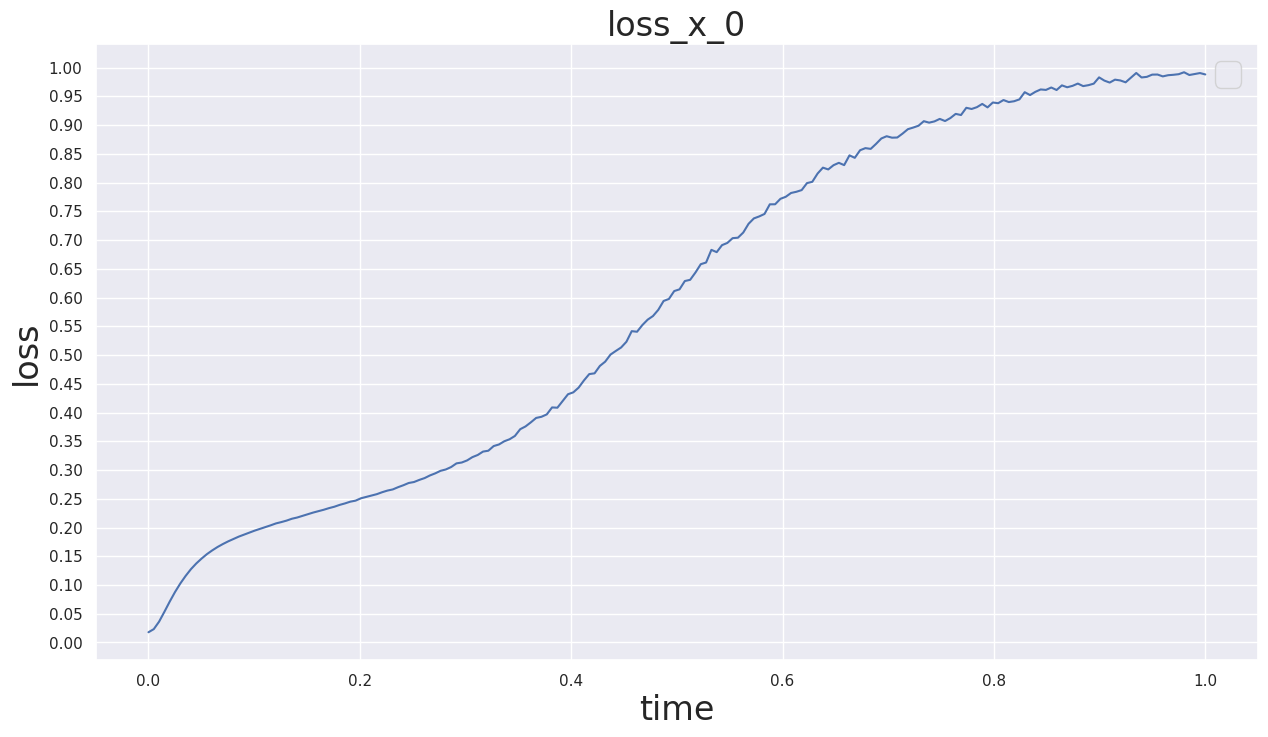

In [39]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("loss_x_0", fontsize=24)
plt.yticks(np.arange(0, 1.01, 0.05))
timesteps = torch.linspace(0, 1, diffusion.diff_eq_solver.sde.N)
plt.plot(timesteps, losses_x_0)

plt.legend(fontsize=24)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


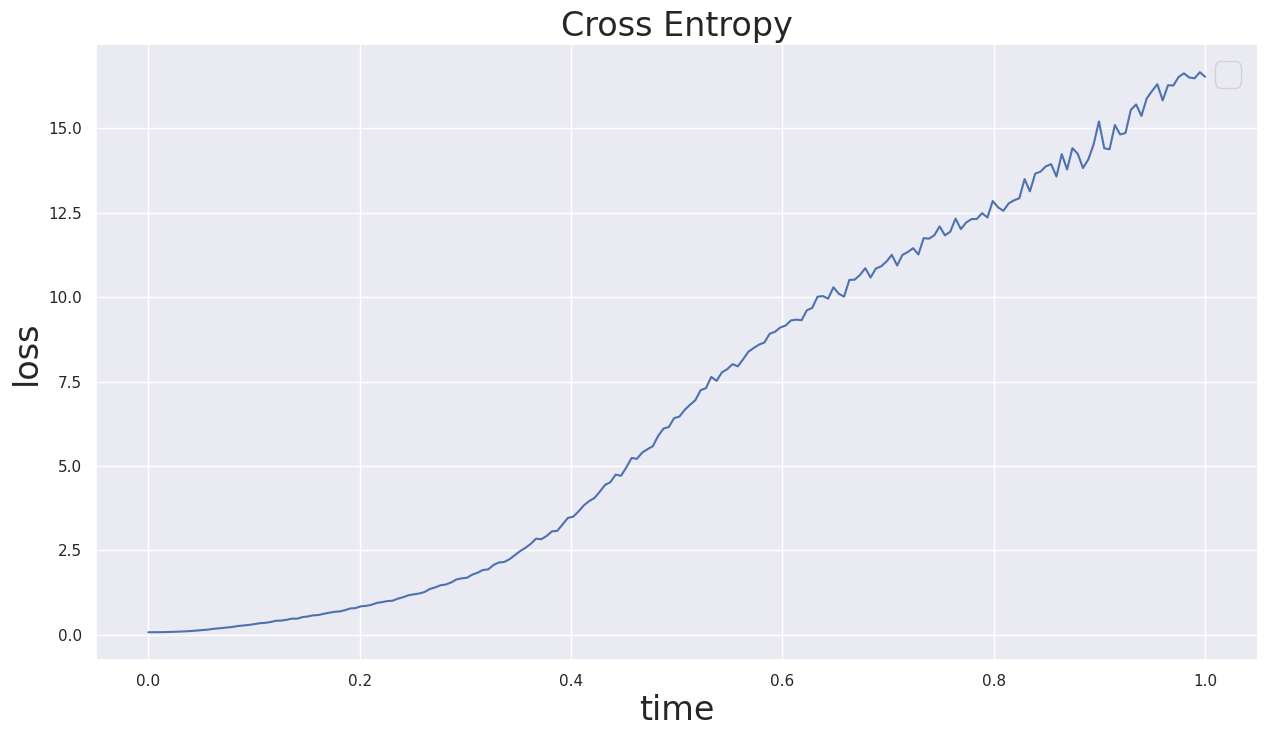

In [40]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("Cross Entropy", fontsize=24)
#plt.yticks(np.arange(0, 1.01, 0.05))
timesteps = torch.linspace(0, 1, diffusion.diff_eq_solver.sde.N)
plt.plot(timesteps, ce_s_text)

plt.legend(fontsize=24)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


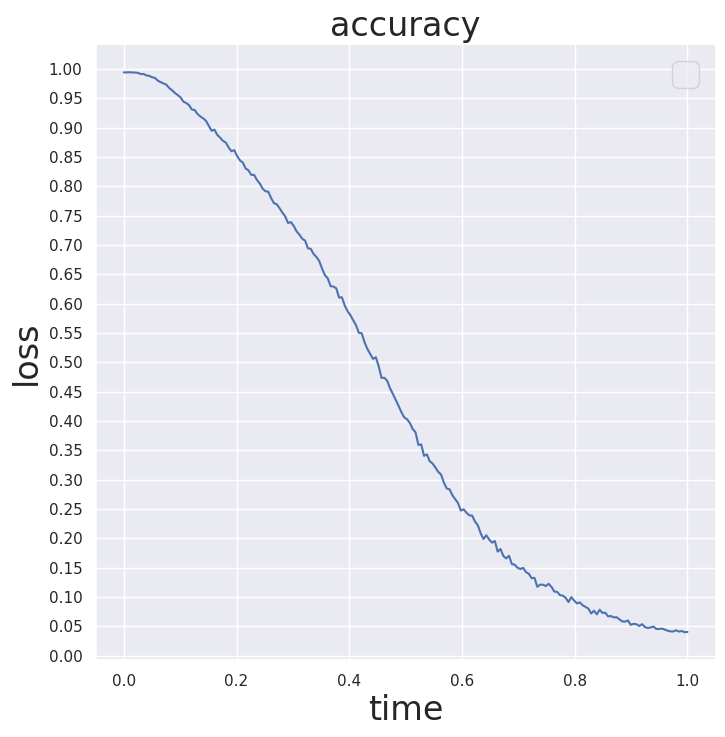

In [46]:
plt.figure(figsize=(8, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("accuracy", fontsize=24)
plt.yticks(np.arange(0, 1.01, 0.05))
timesteps = torch.linspace(0, 1, diffusion.diff_eq_solver.sde.N)
plt.plot(timesteps, acc_s_list)

plt.legend(fontsize=24)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


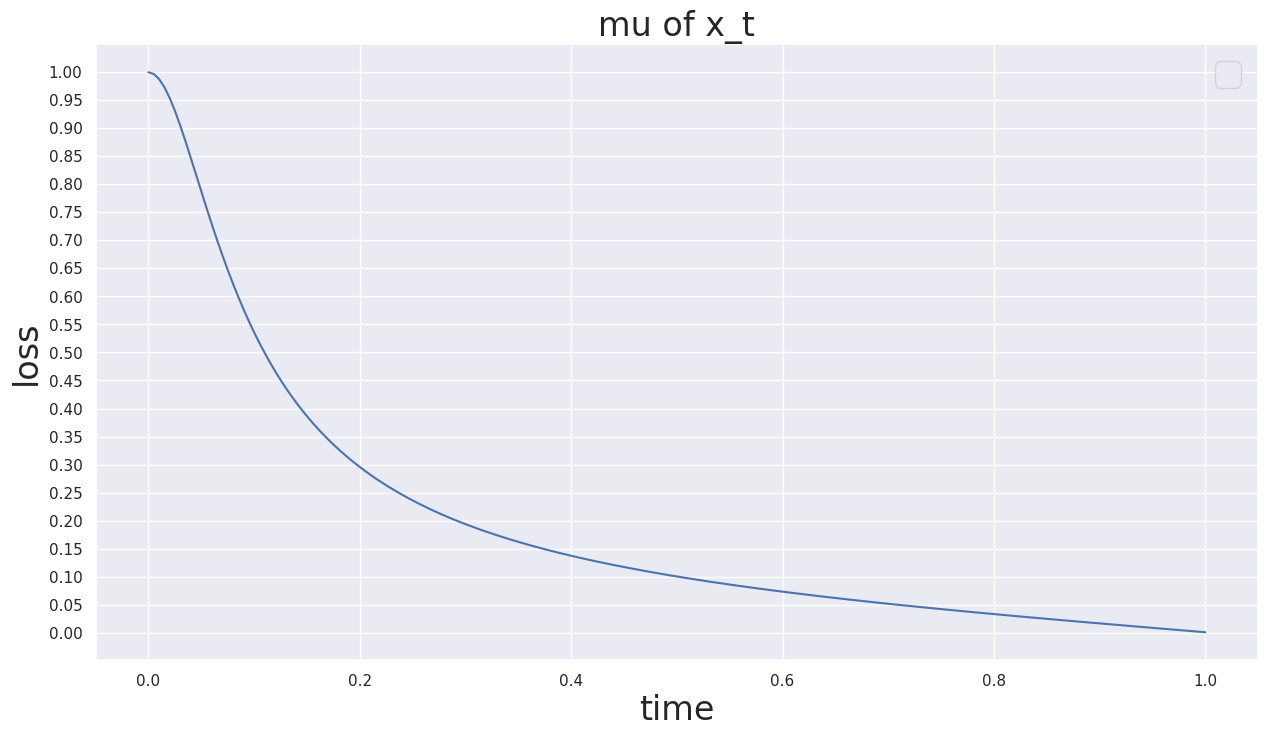

In [44]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("mu of x_t", fontsize=24)
plt.yticks(np.arange(0, 1.01, 0.05))
timesteps = torch.linspace(0, 1, diffusion.diff_eq_solver.sde.N)
plt.plot(timesteps, mu_list)

plt.legend(fontsize=24)
plt.show()